In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}


In [39]:

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=2,
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
for i, j in dataloaders['train']:
    print(model(i))
    break

tensor([[0.0716, 0.1275],
        [0.0649, 0.1060],
        [0.0659, 0.1306],
        [0.0654, 0.1164],
        [0.0685, 0.1094],
        [0.0620, 0.1255],
        [0.0630, 0.1191],
        [0.0676, 0.1165],
        [0.0684, 0.1186],
        [0.0551, 0.1101],
        [0.0641, 0.1162],
        [0.0708, 0.0985],
        [0.0705, 0.1335],
        [0.0643, 0.1216],
        [0.0688, 0.1208],
        [0.0629, 0.1056]], grad_fn=<AddmmBackward0>)


tensor([1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0])
torch.Size([16, 3, 256, 256])


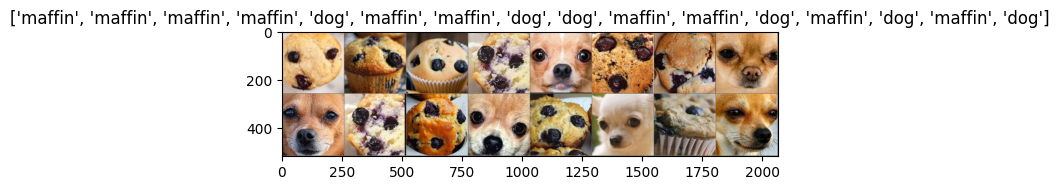

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(classes)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(inputs.shape)

imshow(out, title=[class_names[x] for x in classes])

In [49]:
for i in image_datasets['val']:
    print(i)

(tensor([[[-0.6281, -0.3369, -0.0801,  ..., -1.8610, -1.9124, -1.9980],
         [-0.5253, -0.2342,  0.0398,  ..., -1.7925, -1.8610, -1.9638],
         [-0.4397, -0.1314,  0.1597,  ..., -1.7069, -1.8097, -1.9295],
         ...,
         [ 0.2111,  0.4851,  0.7762,  ...,  0.7077,  0.4166,  0.1768],
         [ 0.5364,  0.7077,  0.8789,  ...,  0.6392,  0.4679,  0.3309],
         [ 0.8961,  0.9817,  1.0502,  ...,  0.6049,  0.5364,  0.4851]],

        [[-1.3880, -1.1604, -0.9328,  ..., -1.9657, -1.9832, -2.0357],
         [-1.3004, -1.0553, -0.8102,  ..., -1.9307, -1.9657, -2.0357],
         [-1.2304, -0.9678, -0.7052,  ..., -1.9132, -1.9657, -2.0357],
         ...,
         [-0.0924, -0.0399,  0.0126,  ...,  0.3277,  0.1702,  0.0126],
         [ 0.0826,  0.0476, -0.0049,  ...,  0.3803,  0.3102,  0.2402],
         [ 0.2227,  0.1001, -0.0574,  ...,  0.4503,  0.4503,  0.4678]],

        [[-1.2816, -1.2990, -1.3164,  ..., -1.7347, -1.7522, -1.8044],
         [-1.3339, -1.3339, -1.3339,  ..., -

In [14]:
# Напишем свой блок свёртки с residual connection

class ResidualBlock(torch.nn.Module):  # Наследуем от torch.nn.Module
    def __init__(  # Инициализация блока
        self,
        input_c,  # Число каналов на входе
        output_c,  # Число каналов на выходе
        kernel_size,  # Размер ядра
        activation=torch.nn.ReLU,  # Класс функции активации
    ):
        super().__init__()
        
        # Функция активации для нелинейности
        self.activation = activation()
        
        # Паддинг подбираем такой, чтобы размеры h и w изображения не менялись
        #  (считаем что размер ядра всегда нечётный)
        padding_size = (kernel_size - 1) // 2
        #padding_size = 0
        
        # Операция свёртки
        self.conv = torch.nn.Conv2d(
            in_channels=input_c,
            out_channels=output_c,
            kernel_size=kernel_size,
            padding=padding_size,
            padding_mode="zeros",
        )
        
        # Если число каналов у входа и выхода различаются, то будем делать свёртку с
        #  ядром размера 1
        if input_c != output_c:
            self.correct_channels = torch.nn.Conv2d(
                in_channels=input_c,
                out_channels=output_c,
                kernel_size=1,
            )
        else:
            self.correct_channels = torch.nn.Identity()  # Слой, никак не меняющий вход
    
    def forward(self, x):  # Прямой проход
        return self.activation(self.conv(x) + self.correct_channels(x))

In [18]:
# Соберём вручную простую свёрточную нейросеть, используя написанный ранее блок
from collections import OrderedDict

conv_layers = [
    (
        "residual_block_1",
        ResidualBlock(
            input_c=3,
            output_c=8,
            kernel_size=5,
            activation=torch.nn.ReLU,
        ),
    ),
    (
        "pooling1",
        torch.nn.MaxPool2d(kernel_size=2),
    ),
    (
        "residual_block_2",
        ResidualBlock(
            input_c=8,
            output_c=4,
            kernel_size=5,
            activation=torch.nn.ReLU,
        ),
    ),
    (
        "pooling2",
        torch.nn.MaxPool2d(kernel_size=4),
    ),
    (
        "flattening",
        nn.Flatten()
    )
]
lin_leyers = [
    (
        "linear_1",
        torch.nn.Linear(
            in_features=32 * 32 * 4,
            out_features=16 * 16 * 8,
        ),
    ),
    (
        "linear_activation_1",
        torch.nn.ReLU(),
    ),
    (
        "linear_2",
        torch.nn.Linear(
            in_features=16 * 16 * 8,
            out_features=8 * 8 * 4,
        ),
    ),
    (
        "linear_activation_2",
        torch.nn.ReLU(),
    ),
    (
        "linear_3",
        torch.nn.Linear(
            in_features=8 * 8 * 4,
            out_features=4 * 4 * 2,
        ),
    ),
    (
        "linear_activation_3",
        torch.nn.ReLU(),
    ),
    (
        "linear_4",
        torch.nn.Linear(
            in_features=4 * 4 * 2,
            out_features=2,
        ),
    )
]

conv_model = torch.nn.Sequential(OrderedDict(conv_layers))
lin_model = torch.nn.Sequential(OrderedDict(lin_leyers))
model = torch.nn.Sequential(conv_model, lin_model)
print(model)

Sequential(
  (0): Sequential(
    (residual_block_1): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (correct_channels): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
    )
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (residual_block_2): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(8, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (correct_channels): Conv2d(8, 4, kernel_size=(1, 1), stride=(1, 1))
    )
    (pooling2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (flattening): Flatten(start_dim=1, end_dim=-1)
  )
  (1): Sequential(
    (linear_1): Linear(in_features=4096, out_features=2048, bias=True)
    (linear_activation_1): ReLU()
    (linear_2): Linear(in_features=2048, out_features=256, bias=True)
    (linear_activation_2): ReLU()
    (linear_3): Linear(in_features=256, out_features=32,

In [37]:
# Напишем цикл обучения модели
from IPython.display import clear_output

# Для ускорения обучения используем видеокарту компьютера или виртуальной машины
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 40
val_every = 5
batch_size = 16

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
)

# Шедулер - отвечает за изменение шага градиентного спуска (постепенно будем уменьшать со временем)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

loss_fn = torch.nn.CrossEntropyLoss()

losses = {"train": [], "val": []}

for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()
    
    #pred_of_model = []
    train_inputs, train_classes = next(iter(dataloaders['train']))
    #print(train_classes)
    correct_pred = []
    for ans in train_classes:
        if ans == 0:
            correct_pred.append([1.0, 0.0])
        elif ans == 1:
            correct_pred.append([0.0, 1.0])
    train_classes = torch.Tensor(correct_pred)
    
    '''for image in train_inputs:
        pred = conv_model(image)
        pred = pred.max(-1).values.max(-1).values
        pred = lin_model(pred)
        if pred[0] > pred[1]:
            pred_of_model.append(0.0)
        else:
            pred_of_model.append(1.0)'''
    pred_of_model = model(train_inputs)
    #print(pred_of_model)
    
    '''pred_of_model = torch.Tensor(pred_of_model)
    pred_of_model = pred_of_model.to(torch.float64)
    '''
    loss = loss_fn(pred_of_model, train_classes)
    #print(loss)
    loss.backward()
    optimizer.step()
    
    losses["train"].append(loss.item())
print(losses)

{'train': [0.09423044323921204, 1.3606044054031372, 0.10011405497789383, 0.12284943461418152, 0.634289562702179, 0.21024103462696075, 0.332317978143692, 0.10766419768333435, 0.10975341498851776, 0.21349288523197174, 0.16989286243915558, 0.1748945266008377, 0.15352188050746918, 0.06331632286310196, 0.0880061686038971, 0.0703829824924469, 0.07125730812549591, 0.051907215267419815, 0.03465653955936432, 0.007235477678477764, 0.024582363665103912, 0.014322380535304546, 0.01644798368215561, 0.004565602168440819, 0.001362779294140637, 0.004181711934506893, 0.00401653815060854, 0.0004447079263627529, 0.0008667933871038258, 0.003176687052473426, 0.0007322521414607763, 0.0013017839519307017, 0.0003006628539878875, 0.00023433673777617514, 4.406152947922237e-05, 3.060030940105207e-05, 5.312997382134199e-05, 1.76400899363216e-05, 0.00010914009908447042, 7.394386921077967e-05], 'val': []}


In [46]:
for i, j in dataloaders['val']:
    print(j)
    print(model(i))
    break

tensor([1, 0])
tensor([[-10.3706,  17.3721],
        [  8.4930,  -6.1552]], grad_fn=<AddmmBackward0>)
